<a href="https://colab.research.google.com/github/MarshaKamsteeg/TM10007_Machine_Learning_Group_Assignment/blob/main/tm10007_group_9_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Description of data set
Import data from the ADNI dataset. Find empty values if present. 

In [ ]:
# Import Data
from adni.load_data import load_data
import numpy as np
import pandas as pd

# Import Data
data = load_data()
data_pandas = pd.DataFrame(data)
print(f'Total number of samples: {len(data.index)}')
print(f'Total number of columns: {len(data.columns)}')
print(f'Total amount of features: {len(data.columns)-2}')

# Find empty / NaN entry in pandas dataframe
data_pandas = data_pandas.replace(' ', np.nan) 
empty_values = np.where(pd.isnull(data_pandas))

if ~empty_values[0] == []:
  print(f'Empty values can be found at index {empty_values}')
else:
  print('There are no empty values found.')
  pass

# Percentage AD and CN
number_AD = data_pandas['label'].value_counts()['AD']
number_CN = data_pandas['label'].value_counts()['CN']
print(f"Within the dataset {number_AD} samples are from people with Alzheimer Disease")
print(f"The other {number_CN} samples are from people without Alzheimer Disease") 


Total number of samples: 855
Total number of columns: 268
Total amount of features: 266
There are no empty values found.
Within the dataset 519 samples are from people with Alzheimer Disease
The other 336 samples are from people without Alzheimer Disease


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


# Preprocessing of the data

## Dividing data in a designset (80%) and testset (20%)

In [ ]:
# import modules
from sklearn.model_selection import train_test_split

# Divide data in label and feature set 
labels = data['label']
features = data.drop(columns=['label'])

# Divide data in trainingsset (80%) and testset (20%) stratified for the label
data_designset, data_testset, label_designset, label_testset = train_test_split(features, labels, test_size=.2, random_state=1, stratify=data['label'])

# Check the stratification 
percent_AD_train = (label_designset.value_counts()['AD'])/len(label_designset)*100
percent_CN_train = (label_designset.value_counts()['CN'])/len(label_designset)*100
percent_AD_test = (label_testset.value_counts()['AD'])/len(label_testset)*100
percent_CN_test = (label_testset.value_counts()['CN'])/len(label_testset)*100

print(f"{percent_AD_train:.2f}% of the train data are Alzheimer disease samples.")
print(f"{percent_CN_train:.2f}% of the train data are control samples.")
print(f"{percent_AD_test:.2f}% of the test data are Alzheimer disease samples.")
print(f"{percent_CN_test:.2f}% of the test data are control samples.")


60.67% of the train data are Alzheimer disease samples.
39.33% of the train data are control samples.
60.82% of the test data are Alzheimer disease samples.
39.18% of the test data are control samples.


## Feature Dropping

Find columns where > 90% of the column has value zero. Remove the features if this is true. Besides, remove features if the whole column has one unique value. 

In [ ]:
data_designset = data_designset.drop(columns=data_designset.columns[data_designset.eq(0).mean()>0.9])
data_designset = data_designset[data_designset.columns[data_designset.nunique() > 1]]
data_designset_feature_names = data_designset.columns

# Eventueel verwijderen als meer dan 90% hetzelfde is. 
# Toevoegen welke kolom die verwijdert.

## Scaling

In [ ]:
# Different methods for feature scaling. Decision will be made after usage of PCA
# Import modules
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# # Robust scaler - based on percentiles. Not influenced by a few number of very large marginal outliers
# trans = RobustScaler()
# x_train_robust = trans.fit_transform(x_train)

# # Standard scaler - removes the mean and scales the data to unit variance
# scaler = StandardScaler()
# x_train_scaler = scaler.fit_transform(x_train)

# MinMax scaler - rescales data set such that all feature values are in range [0,1]
norm = MinMaxScaler().fit(data_designset)
data_designset_norm = norm.transform(data_designset)
data_designset_norm = pd.DataFrame(data_designset_norm)
data_designset_norm.columns = data_designset_feature_names

# Cross validation
First a stratified k fold cross validation is used with 10 splits. 
Feature selection - best method to select features from this multi feature space. The options looked in to are:
1. Univariate
2. Univariate + PCA
3. PCA

Classifier - best classifier with the remaining features. Three classifiers are looked in to based on literature review.
1. K-NN (normalized scaler)
2. SVM 
3. CNN

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors, metrics
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
k_list = list(range(1, 25, 2))
all_train = []
all_val = []

for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  train_scores = []
  validation_scores = []

  # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
  bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
  fit = bestfeatures.fit(x_train, y_train)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(data_designset_norm.columns)

  # A threshold is set on 0.7 times the maximum scoring feature.
  feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
  feature_scores.columns = ['Specs','Score']  
  feature_scores = feature_scores.sort_values('Score')
  highest_feature_score = feature_scores['Score'].iloc[-1]
  threshold_feature_relative = 0.7                                                  # Optimization of parameter is needed
  threshold_feature_score = threshold_feature_relative*highest_feature_score
  criteria = feature_scores['Score']>=threshold_feature_score

  # Every feature scoring above the threshold will be selected. 
  feature_selection_names = []
  for i in range(0,len(feature_scores['Score'])):
    if feature_scores['Score'].iloc[i]>=threshold_feature_score:
      feature_selection_names.append(feature_scores['Specs'].iloc[i])

  selected_data_designset_norm = data_designset_norm[feature_selection_names]
  print(selected_data_designset_norm)

     hf_quartile_range  tf_LBP_std_R3_P12  hf_kurtosis  hf_entropy
0             0.198266           0.395872     0.150718    0.803665
1             0.064497           0.763401     0.499410    0.314725
2             0.038575           0.766152     0.494095    0.247117
3             0.702242           0.330794     0.008194    0.837324
4             0.049570           0.759462     0.620899    0.215376
..                 ...                ...          ...         ...
679           0.118290           0.588258     0.685016    0.357894
680           0.039349           0.726369     0.525931    0.299269
681           0.293117           0.479401     0.153013    0.612099
682           0.076101           0.565875     0.527578    0.433078
683           0.736996           0.420677     0.002345    0.862490

[684 rows x 4 columns]
       hf_std  hf_quartile_range  hf_kurtosis  hf_entropy
0    0.281948           0.198266     0.150718    0.803665
1    0.138342           0.064497     0.499410    0.31472

## Cross Validation splitting of dataset

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors, metrics
import seaborn
import matplotlib.pyplot as plt

# configure the cross-validation procedure
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
k_list = list(range(1, 25, 2))
all_train = []
all_val = []

for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  train_scores = []
  validation_scores = []

# for k in k_list:
#         clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
#         clf_knn.fit(X_train, y_train)

#         # Test the classifier on the training data and plot
#         score_train = clf_knn.score(X_train, y_train)
#         score_val = clf_knn.score(X_val, y_val)
    
#         train_scores.append(score_train)
#         validation_scores.append(score_val)
    
#     all_train.append(train_scores)
#     all_val.append(validation_scores)
    
# # Create numpy array of scores and calculate the mean and std
# all_train = np.array(all_train)
# all_val = np.array(all_val)

# train_scores_mean = all_train.mean(axis=0)
# train_scores_std = all_train.std(axis=0)

# val_scores_mean = all_val.mean(axis=0)
# val_scores_std = all_val.std(axis=0)

# # Plot the mean scores and the std as shading
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111)
# ax.grid()
# ax.fill_between(k_list, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
# ax.fill_between(k_list, val_scores_mean - val_scores_std,
#                      val_scores_mean + val_scores_std, alpha=0.1,
#                      color="g")
# ax.plot(k_list, train_scores_mean, 'o-', color="r",
#         label="Training score")
# ax.plot(k_list, val_scores_mean, 'o-', color="g",
#         label="Validation score")


### Univariate Feature Selection 

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import math 

bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
fit = bestfeatures.fit(data_designset_norm, label_designset)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data_designset_norm.columns)

feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
feature_scores.columns = ['Specs','Score']  
feature_scores = feature_scores.sort_values('Score')
highest_feature_score = feature_scores['Score'].iloc[-1]
threshold_feature_relative = 0.7                                                  # Optimization of parameter is needed
threshold_feature_score = threshold_feature_relative*highest_feature_score
criteria = feature_scores['Score']>=threshold_feature_score

feature_selection_names = []
for i in range(0,len(feature_scores['Score'])):
  if feature_scores['Score'].iloc[i]>=threshold_feature_score:
    feature_selection_names.append(feature_scores['Specs'].iloc[i])

selected_data_designset_norm = data_designset_norm[feature_selection_names]

# print(feature_scores.nlargest(50,'Score'))  


Best classifier: k=15
Best classifier: k=21
Best classifier: k=11
Best classifier: k=9
Best classifier: k=13
Best classifier: k=13
Best classifier: k=23
Best classifier: k=11
Best classifier: k=13
Best classifier: k=17
The optimal N=13


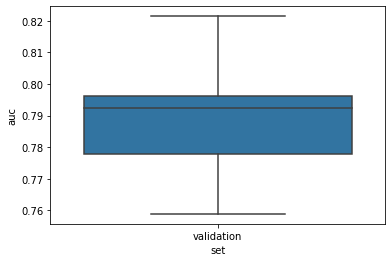

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import neighbors, metrics
import seaborn

# # Create a X fold stratified CV iterator
# cv_outer = StratifiedKFold(n_splits=10)
# results = []
# best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_outer.split(features, labels):
    
		# Split the data properly
    data_train_val = features.to_numpy()[validation_index]
    label_train_val = labels.to_numpy()[validation_index]
   
    data_test = features.to_numpy()[test_index]
    label_test = labels.to_numpy()[test_index]

    # Check the stratification 
    # percent_AD_train = (label_train_val == 'AD').sum()/len(label_train_val)*100
    # percent_CN_train = (label_train_val == 'CN').sum()/len(label_train_val)*100
    # percent_AD_test = (label_test == 'AD').sum()/len(label_test)*100
    # percent_CN_test = (label_test == 'CN').sum()/len(label_test)*100
    # print(f"{percent_AD_train:.2f}% of the train data are Alzheimer disease samples.")
    # print(f"{percent_CN_train:.2f}% of the train data are control samples.")
    # print(f"{percent_AD_test:.2f}% of the test data are Alzheimer disease samples.")
    # print(f"{percent_CN_test:.2f}% of the test data are control samples.")
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 10, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_inner = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(knn, parameters, cv=cv_inner.split(data_train_val, label_train_val), scoring='accuracy')
    grid_search.fit(data_train_val, label_train_val)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)

# 		# Test the classifier on the test data
#     probabilities = clf.predict_proba(data_test)
#     scores = probabilities[:, 1]
    
#     # Get the auc
#     auc = metrics.roc_auc_score(label_test, scores)
#     results.append({
#         'auc': auc,
#         'k': clf.n_neighbors,
#         'set': 'test'
#     })
    
    # Test the classifier on the validation data
    probabilities_train_val = clf.predict_proba(data_train_val)
    scores_train_val = probabilities_train_val[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(label_train_val, scores_train_val)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")

# Classifiers
## PCA

In [ ]:
# General Import
from sklearn.decomposition import PCA

# Create a PCA which retains n principle components
n_pca = 5
pca = PCA(n_components=n_pca)

# Fit the PCA model, point_data_train should be a 2D numpy array
# which has one row per subject and the pointdata as columns where
# the columns are x1, y1, z1, x2, y2, z2, ..., xn, yn, zn
pca.fit(data_trainset)

# Transform data
data_trainset_trans = pca.transform(data_trainset)
